In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib 
import numpy as np
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
import pyiast
plt.style.use("default")
matplotlib.rc('font', size=10)
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import os
from sklearn import neighbors

In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

# Loading in Data

In [2]:
mofs = ["HKUST-1", "MOF-5"]
gases = ["co2", "ch4"]
molecular_weight = {"ch4":16.04, "co2":44.01}
df = dict()
for mof in mofs:
    df[mof] = dict()
    for gas in gases:
        df[mof][gas] = pd.read_csv(os.path.join("adsorption_data", gas + "_" + mof + "_25C.csv"), skiprows = 1)
        if gas == "ch4":
            df[mof][gas]["N(mmol/g)"] = df[mof][gas]["N(cm3/g)"] / 22.4
        df[mof][gas]["N(g/g)"] = df[mof][gas]["N(mmol/g)"] * molecular_weight[gas] / 1000 

df["MOF-5"]["co2"]

,P(bar),N(mmol/g),N(g/g)
0,0.0,0.0,0.000000
1,1.2,1.1,0.048411
2,2.1,1.8,0.079218
3,3.2,2.8,0.123228
4,4.1,3.7,0.162837
5,5.3,4.9,0.215649
6,6.3,6.1,0.268461
7,7.2,7.1,0.312471
8,8.2,8.4,0.369684
9,9.4,10.1,0.444501


# Construct Adsorption Models

co2 in HKUST-1


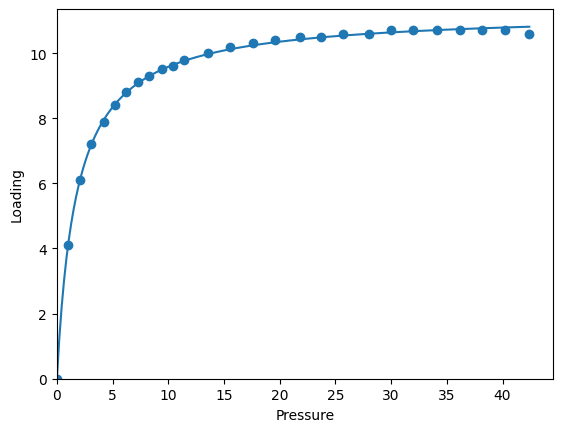

ch4 in HKUST-1


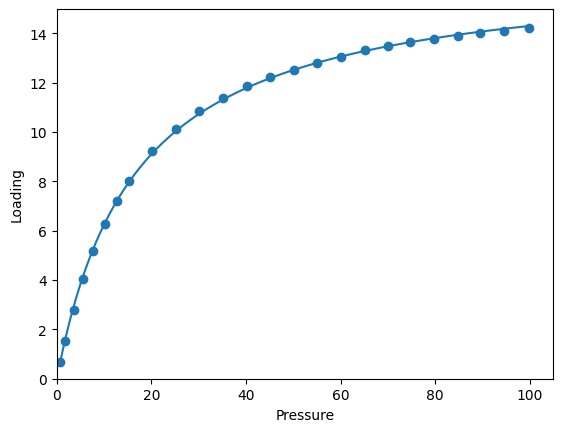

co2 in MOF-5


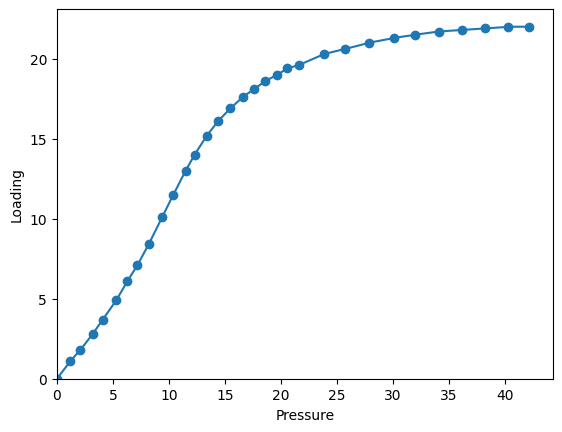

ch4 in MOF-5


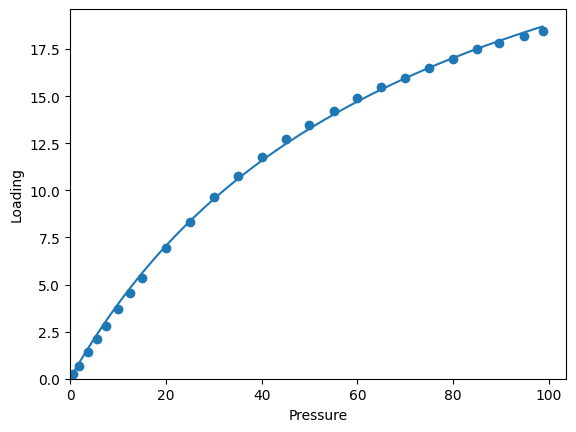

In [3]:
ads_model = dict()
for mof in mofs:
    ads_model[mof] = dict()
    for gas in gases:
        print(gas + " in " + mof)
        if gas == "co2" and mof == "MOF-5":
            ads_model[mof][gas] = pyiast.InterpolatorIsotherm(df[mof][gas],
                                                        pressure_key="P(bar)",
                                                        loading_key="N(mmol/g)", 
                                                        fill_value=df[mof][gas]["N(mmol/g)"].max()) 
        else:
            ads_model[mof][gas] = pyiast.ModelIsotherm(df[mof][gas],
                                                        pressure_key="P(bar)",
                                                        loading_key="N(mmol/g)",
                                                        model="Langmuir")
        pyiast.plot_isotherm(ads_model[mof][gas])

In [4]:
ads_model["HKUST-1"]["co2"].params

{'M': 11.258065277579124, 'K': 0.57196295270447}

In [5]:
ads_model["HKUST-1"]["co2"].loading(0.2)

1.1556423315374746

In [6]:
ads_model["MOF-5"]["co2"].loading(1330.0)

array(22.)

In [7]:
"""
    m = f(p)

return adsorbed mass in the MOFs as a function of pressure.

both m and p are arrays here.

m[i]: total mass adsorbed in MOF i
p[i]: partial pressure of gas i
"""
def f(p):
    if np.any(p < 0.0):
        return np.array([-100.0 * np.linalg.norm(p), -100.0 * np.linalg.norm(p)])
    m = np.zeros(2)
    for i, mof in enumerate(mofs):
        # if gas is pure gas 1
        if p[0] == 0.0:
            m[i] = ads_model[mof][gases[1]].loading(p[1])
            continue
        #  if gas is pure gas 0
        if p[1] == 0.0:
            m[i] = ads_model[mof][gases[0]].loading(p[0])
            continue
        # if reached this far, need IAST
        # first, a reasonable guess for adsorbed_mole_fraction_guess
        #  based on pure-component loadings
        m_guess = np.zeros(2)
        for g, gas in enumerate(gases):
            m_guess[g] = ads_model[mof][gas].loading(p[g])
        m_guess = m_guess / np.sum(m_guess)
        q = pyiast.iast(p, [ads_model[mof][gases[0]], ads_model[mof][gases[1]]],
                        verboseflag=False, adsorbed_mole_fraction_guess=m_guess, warningoff=True)
        m[i] = np.sum(q)
    return m

# turn warningoff=False to see if there are warnings.

In [8]:
p = np.array([5.0, 4.0])
m = f(p)
m

array([8.87900924, 6.34877264])

## NN algo for good guess
forward function `f` is robust.

inverse function is not... so let's use nearest neighbors to get a good guess for the inverse function.

In [9]:
ps = np.linspace(0, 10.0, 35)
knn = neighbors.KNeighborsRegressor(1)
P = []
M = []
for i in range(len(ps)):
    for j in range(len(ps)):
        p = np.array([ps[i], ps[j]])
        P.append(p)
        M.append(f(p))
knn_model = knn.fit(M, P) # the inverse problem

def g_knn(m):
    return knn_model.predict([m])[0]

g_knn(m)

/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


array([5.29411765, 3.23529412])

# Adsorption model $\mathbf{m}(\mathbf{p})$

In [10]:
### Old adsorption model without data ###

# Langmuir params for MOF 2
# K2 = [0.1, 0.5]
# M2 = 1.0
# # Langmuir params for MOF 1
# K1 = [0.7, 0.3]
# M1 = 2.0

# # f is the forward function
# def f_1(p):
#     return M1 * np.dot(K1, p) / (1 + np.dot(K1, p))

# def f_2(p):
#     return M2 * np.dot(K2, p) / (1 + np.dot(K2, p))

# def f(p): #p is a vector
#     return [f_1(p), f_2(p)]

# Inverse of adsorption model $\mathbf{p}(\mathbf{m})$

In [11]:
"""
    p = g(m)

inverse of f(p). i.e. given m, return p that produces it.
if not a successful root finding, return Nans
"""
def g(m): 
    #  we want this function to return a zero vector
    #  it takes in a pressure p
    #  it outputs the corresponding difference between the response and the response m_0 that we find
    #  if we find the right p that gives us the response m_0, then this will be the zero vector
    def f_want_0(p):
        return (f(p) - m) * 2
    p_guess = g_knn(m)
    sol = optimize.root(f_want_0, p_guess)
    p = sol.x
    # return nan if p less than lower bound, greater than upper bound
#     if p[0] < p_lb or p[1] < p_lb or p[0] > p_ub or p[1] > p_ub:
#         return np.array([np.nan, np.nan])
#     if not sol.success:
#         return np.array([np.nan, np.nan])
    return p

In [12]:
g(m)

array([5., 4.])

# $\kappa$ for inverse problem 

In [13]:
ads_model["MOF-5"]["ch4"].params

{'M': 32.246842920360606, 'K': 0.013992308846397912}

In [14]:
# gets inverse condition number in terms of p
def κ_of_p(p, mof1, mof2, gas):
    J_f = np.array([[ads_model[mof1][gas].params["M"]*K1[0]/(1 + np.dot(K1, p))**2, 
                    ads_model[mof1][gas].params["M"]*K1[1]/(1 + np.dot(K1, p))**2],
                    [ads_model[mof2][gas].params["M"]*K2[0]/(1 + np.dot(K2, p))**2, 
                    ads_model[mof2][gas].params["M"]*K2[1]/(1 + np.dot(K2, p))**2]])
    J_g = np.linalg.inv(J_f) # by inverse function theorem
 
    # Check that norm of J_g is equal to 1/smallest singlular value of J_f
#     u, s, vh = np.linalg.svd(J_f)
#     print("norm of J_g: ", np.linalg.norm(J_g, ord=2) )
#     print("1/smallest singular value of J_f: ", 1/s[-1])
#     print((  np.linalg.norm(m) / np.linalg.norm(p)) * (1 / s[-1]))
    
    #return (  np.linalg.norm(m) / np.linalg.norm(p)) * (1 / s[-1])
    return np.linalg.norm(J_g, ord=2)



# # gets inverse condition number in terms of p
# def κ_of_p(p):
#     J_f = np.array([ [M1*K1[0]/(1 + np.dot(K1, p))**2, M1*K1[1]/(1 + np.dot(K1, p))**2],
#        [M2*K2[0]/(1 + np.dot(K2, p))**2, M2*K2[1]/(1 + np.dot(K2, p))**2]])
#     J_g = np.linalg.inv(J_f) # by inverse function theorem
 
#     # Check that norm of J_g is equal to 1/smallest singlular value of J_f
# #     u, s, vh = np.linalg.svd(J_f)
# #     print("norm of J_g: ", np.linalg.norm(J_g, ord=2) )
# #     print("1/smallest singular value of J_f: ", 1/s[-1])
# #     print((  np.linalg.norm(m) / np.linalg.norm(p)) * (1 / s[-1]))
    
#     #return (  np.linalg.norm(m) / np.linalg.norm(p)) * (1 / s[-1])
#     return np.linalg.norm(J_g, ord=2)

# Bivariate Color Map

In [15]:
def colorFromBivariateData(x,y,cmap1 = plt.cm.Greens, cmap2 = plt.cm.YlOrRd):
    if np.any(x > 1) or np.any(y > 1):
        raise Exception("Numbers must be between 0 and 1.")
    if np.any(np.isnan(x)) or np.any(np.isnan(y)):
        return np.array([1, 1, 1, 1])
    x_color = cmap1(x)
    y_color = cmap2(y)

    # Color for each point
    xy_color = np.sum([x_color, y_color], axis=0)/2.0

    return xy_color

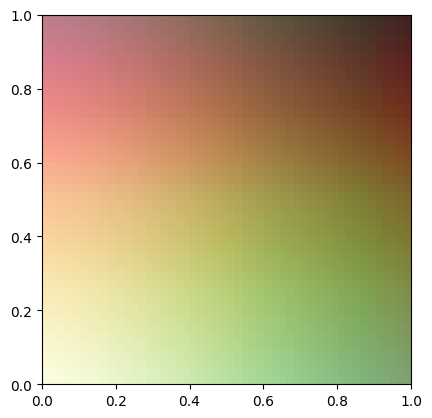

In [16]:
# Example of colorFromBivariateData function
x = np.linspace(0, 1)
y = np.linspace(0, 1)
z = [[colorFromBivariateData(x[i], y[j]) for i in range(np.size(x))] for j in range(np.size(y))]
extent = (0, 1, 0, 1) #figure out how to put our desired x/y lims on this
plt.imshow(z, extent=extent, origin='lower')

# Functions to draw grid lines

In [17]:
# function to draw vertial grid line on plot
def draw_vert_line(x, y_min, y_max, plt_num):
    ax[plt_num].plot([x, x], [y_min, y_max], color="black", lw=3)  

# function to draw horizontal grid line on plot
def draw_horizontal_line(y, x_min, x_max, plt_num):
    ax[plt_num].plot([x_min, x_max], [y, y], color="black", lw=3) 

# Functions to determine valid ranges of m1, m2

In [18]:
#f([0, pB], mof)

#### Functions to get valid m values to draw vertical grid lines ####
def find_pa_vert(m1): #find pa given that f_1([pa,0]) = m1
    return m1 / ((M1 - m1) * K1[0])

def find_pb_vert(m1): #find pb given that f_1([0, pb]) = m1
    return m1 / ((M1 - m1) * K1[1])

def find_pa_vert_pmax(m1): #find pa given that f_1([pa,p_max]) = m1
    return (m1 + m1*K1[1]*p_max - M1*K1[1]*p_max) / ((M1 - m1) * K1[0])

def find_pb_vert_pmax(m1): #find pb given that f_1([p_max, pb]) = m1
    return (m1 + m1*K1[0]*p_max - M1*K1[0]*p_max) / ((M1 - m1) * K1[1])

def valid_m2(m1): #find valid m2 value range for m1 
    pa = find_pa_vert(m1)
    pb = find_pb_vert(m1)   
    if pb > p_max and pa < p_max:
        m2_min = f([pa, 0])[1]
        m2_max = f([find_pa_vert_pmax(m1), p_max])[1]
    elif pb > p_max and pa > p_max:
        m2_min = f([p_max, find_pb_vert_pmax(m1)])[1]
        m2_max = f([find_pa_vert_pmax(m1), p_max])[1]
    else:
        m2_min = f([pa, 0])[1]
        m2_max = f([0, pb])[1]
    return m2_min, m2_max

In [19]:
#### Functions to get valid m values to draw horizontal grid lines ####
def find_pa_horizontal(m2): #find pa given that f_1([pa,0]) = m2
    return m2 / ((M2 - m2) * K2[0])

def find_pb_horizontal(m2): #find pb given that f_1([0, pb]) = m2
    return m2 / ((M2 - m2) * K2[1])

def find_pa_horizontal_pmax(m2): #find pa given that f_1([pa,p_max]) = m2
    return (m2 + m2*K2[1]*p_max - M2*K2[1]*p_max) / ((M2 - m2) * K2[0])

def find_pb_horizontal_pmax(m2): #find pb given that f_1([p_max, pb]) = m2
    return (m2 + m2*K2[0]*p_max - M2*K2[0]*p_max) / ((M2 - m2) * K2[1])

def valid_m1(m2): #find valid m1 value range for m2 
    pa = find_pa_horizontal(m2)
    pb = find_pb_horizontal(m2)   
    if pa > p_max and pb < p_max:
        m1_min = f_1([0, pb])
        m1_max = f_1([p_max, find_pb_horizontal_pmax(m2)])
    elif pa > p_max and pb > p_max:
        m1_min = f_1([find_pa_horizontal_pmax(m2), p_max])
        m1_max = f_1([p_max, find_pb_horizontal_pmax(m2)])
    else:
        m1_min = f_1([0, pb])
        m1_max = f_1([pa, 0])    
    return m1_min, m1_max

# Function to draw boundary on response space

In [20]:
# Function to draw boundary around response space figure
def draw_mspace_boundaries(p_max, plt_num):
    x = np.linspace(0, p_max, 50) 
    m1 = np.zeros(len(x))
    m2 = np.zeros(len(x))
    for i in range(len(x)):
        # make pa = 0
        p = np.array([0, x[i]])
        m1[i] = f(p)[0] 
        m2[i] = f(p)[1]
    ax[plt_num].plot(m1,m2, color="black", lw=3)
    for i in range(len(x)):        
        # make pb = 0
        p = np.array([x[i], 0])
        m1[i], m2[i] = f(p) 
    ax[plt_num].plot(m1,m2,color="black", lw=3)
    for i in range(len(x)):        
        # make pa = max
        p = np.array([p_max, x[i]])
        m1[i], m2[i] = f(p) 
    ax[plt_num].plot(m1,m2,color="black", lw=3)
    for i in range(len(x)):        
        # make pb = max
        p = np.array([x[i], p_max])
        m1[i], m2[i] = f(p) 
    ax[plt_num].plot(m1,m2,color="black", lw=3)

# Mapping Composition Space to Response Space

/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: inval

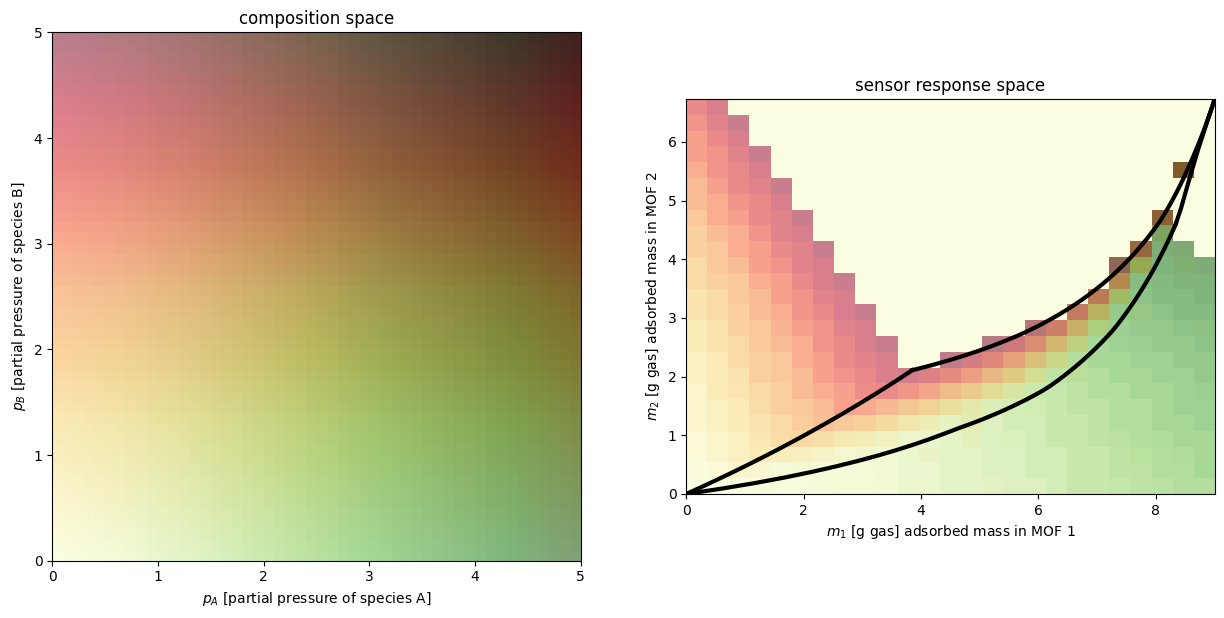

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
###
#   composition space
###
ax[0].set_title("composition space")
ax[0].set_xlabel("$p_A$ [partial pressure of species A]")
ax[0].set_ylabel("$p_B$ [partial pressure of species B]")

###
#   sensor response space
###
ax[1].set_aspect('equal', 'box')
ax[1].set_title("sensor response space")
ax[1].set_xlabel("$m_1$ [g gas] adsorbed mass in MOF 1")
ax[1].set_ylabel("$m_2$ [g gas] adsorbed mass in MOF 2")

###
#   draw grid lines and their mapping
###
p_max = 5.0 # largest pressure we go to.
dp = 0.5 # spacing between grid lines
nb_pts = 50
# these arrays will contain the correponding reponses to each point on the lines.
m1 = np.zeros(nb_pts)
m2 = np.zeros(nb_pts)
for i in range(int(p_max / dp)+1):
    ###
    #   x = constant (vertical) grid lines
    ###
    p_a = i * dp # p_a is constant here.
    
    # plot the line in composition space
#    draw_vert_line(p_a, 0, p_max, 0)
    
    # plot the image of the line in sensor response space
    p_b = np.linspace(0.0, p_max, nb_pts)

    # loop through points on the line
    for j in range(nb_pts):
        # get vector on this line
        p_on_line = np.array([p_a, p_b[j]])
        # compute the adsorbed mass in the two MOFs when exposed to this gas composition
#        m1[j] = f(p_on_line, mof)[0]
#        m2[j] = f(p_on_line, mof)[1]
#    ax[1].plot(m1, m2, color="black", lw=3)
    
    ###
    #   y = constant (horizontal) grid lines
    ###
    p_b = i * dp # p_b is constant here.
 
    # plot the line in composition space
#    draw_horizontal_line(p_b, 0, p_max, 0)
    
    # plot the image of the line in sensor response space
    p_a = np.linspace(0.0, p_max, nb_pts)

    # loop through points on the line
    for j in range(nb_pts):
        # get vector on this line
        p_on_line = np.array([p_a[j], p_b])
        # compute the adsorbed mass in the two MOFs when exposed to this gas composition
#        m1[j] = f(p_on_line, mof)[0]
#        m2[j] = f(p_on_line, mof)[1]
#    ax[1].plot(m1, m2, color="black", lw=3)
        
###
#   color the plane
###
# Initialize pa, pb for colormap
pa = np.linspace(0, p_max)
pb = np.linspace(0, p_max)

# Create bivariate colormap for composition space
z_composition = [[colorFromBivariateData(pa[i]/p_max, pb[j]/p_max) for i in range(np.size(pa))] for j in range(np.size(pb))]

# find maximum mass
m_max = f(np.array([p_max, p_max]))

# Initialize m1, m2 for colormap
num_grid_pts = 25
m1_grid = np.linspace(0, m_max[0], num_grid_pts)
m2_grid = np.linspace(0, m_max[1], num_grid_pts)

# Initialize response space colormap, 
z_response = [[colorFromBivariateData(0, 0) for i in range(num_grid_pts)] for j in range(num_grid_pts)]

# Modify bivariate colormap for response space based on mapping from composition space 
for i in range(num_grid_pts):
    for j in range(num_grid_pts):
        m_0 = np.array([m1_grid[i], m2_grid[j]])
#         p = g_knn(m_0) # g(m_0, 0, p_max)
        p = g(m_0)
        if np.all(p < p_max):
            z_response[j][i] = colorFromBivariateData(p[0] / p_max, p[1] / p_max)

# Create extent of colormaps
extent_composition = (0, p_max, 0, p_max) 
extent_response = (0, m_max[0], 0, m_max[1])

# Plot colormaps in composition and response space
ax[0].imshow(z_composition, extent=extent_composition, origin='lower')        
ax[1].imshow(z_response, extent=extent_response,  origin='lower') 
ax[1].set_aspect('equal', 'box')
ax[0].set_aspect('equal', 'box')

# Add boarder around response space
draw_mspace_boundaries(p_max, 1)

# Add png to plot
#irmof1_fig = mpimg.imread('irmof1.png')
#imagebox = OffsetImage(irmof1_fig, zoom=0.1)
#ab = AnnotationBbox(imagebox, (4.0, 4.0))
#ax[0].add_artist(ab)

# Testing to ensure points map to correct response space
# p = [0,5]
# m = [f_1(p), f_2(p)]
# print("m :", m)
# ax[0].scatter([p[0]],[p[1]], color='red', s=70)
# ax[1].scatter([m[0]],[m[1]], color='red', s=70)

In [22]:
m = np.array([0.1, 6.0])
g(m)

array([0.        , 3.23529412])

# Mapping Response Space to Composition Space

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
###
#   composition space
###
ax[1].set_title("composition space")
ax[1].set_xlabel("$p_A$ [partial pressure of species A]")
ax[1].set_ylabel("$p_B$ [partial pressure of species B]")
# set composition space to exclude negative pressures 
ax[1].set_xlim(xmin=0, xmax=p_max)
ax[1].set_ylim(ymin=0, ymax=p_max)

###
#   sensor response space
###
ax[0].set_aspect('equal', 'box')
ax[0].set_title("sensor response space")
ax[0].set_xlabel("$m_1$ [g gas] adsorbed mass in MOF 1")
ax[0].set_ylabel("$m_2$ [g gas] adsorbed mass in MOF 2")

###
#   color the plane
###
nb_pts = 100
# Initialize m1, m2 for colormap
m1 = np.linspace(0, m_max[0], nb_pts)
m2 = np.linspace(0, m_max[1], nb_pts)

# Create bivariate colormap for response space
z_response = [[colorFromBivariateData(m1[i]/m_max[0], m2[j]/m_max[1]) for i in range(np.size(m1))] 
                 for j in range(np.size(m2))]

# Modify response space colormap to only have color where presssure is positive
for i in range(np.shape(z_response)[0]):
    for j in range(np.shape(z_response)[1]):
        m_0 = np.array([m1[i], m2[j]])
        p = g(m_0) 
        # zero out (i.e. set color to white) responses that correspond to negative pressures
        if np.any(np.isnan(p)) or np.any(p > p_max):
            z_response[j][i] = np.array([1, 1, 1, 1])
            
# Plot colormap on response space 
ax[0].imshow(z_response, extent=extent_response,  origin='lower')           
ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')    
    
# Create bivariate colormap for composition space based on mapping from response space 
for i in range(np.shape(z_composition)[0]):
    for j in range(np.shape(z_composition)[1]):
        p_0 = np.array([pa[i], pb[j]])
        m = np.array([f_1(p_0), f_2(p_0)])
        # zero out responses that are above m_max
        if np.any(m > m_max):
            z_composition[j][i] = np.array([1, 1, 1, 1])
        else:
            z_composition[j][i] = colorFromBivariateData(m[0]/m_max[0], m[1]/m_max[1])   

# Plot colormap on composition space
ax[1].imshow(z_composition, extent=extent_composition, origin='lower')        

###
#   draw grid lines and their mapping
###
dm = 0.1 # spacing between grid lines
nb_pts = 100
# these arrays will contain the correponding compositions to each point on the lines.
p_a = np.zeros(nb_pts)
p_b = np.zeros(nb_pts)


for i in range(int(max(m_max) / dm)+1):
    ###
    #   x = constant (vertical) grid lines
    ###
    m1 = i * dm # m1 is constant here.

    if m1 < m_max[0]:
        m2_min, m2_max = valid_m2(m1)
        draw_vert_line(m1, m2_min, m2_max, 0)
    
        # plot the image of the line in composition space
        m2 = np.linspace(m2_min, m2_max, nb_pts)

        # loop through points on the line
        for j in range(nb_pts):
            # get vector on this line
            m_on_line = np.array([m1, m2[j]])
            # compute the composition in the gas space when MOFs have this much gas absorbed
            p_a[j], p_b[j] = g(m_on_line) 
        ax[1].plot(p_a, p_b, color="black", lw=3)

    ###
    #   y = constant (horizontal) grid lines
    ###
    m2 = i * dm # m2 is constant here.

    if m2 < m_max[1]:
        m1_min, m1_max = valid_m1(m2)
        draw_horizontal_line(m2, m1_min, m1_max, 0)
        
        # plot the image of the line in composition space
        m1 = np.linspace(m1_min, m1_max, nb_pts)
    
        # loop through points on the line
        for j in range(nb_pts):
            # get vector on this line
            m_on_line = np.array([m1[j], m2])
            # compute the composition in the gas space when MOFs have this much gas absorbed
            p_a[j], p_b[j] = g(m_on_line) 
        ax[1].plot(p_a, p_b, color="black", lw=3)
        
# Add boarder around response space
draw_mspace_boundaries(p_max, 0) 

# Create colormap for composition space
κ_p = [[κ_of_p(np.array([pa, pb])) for pa in p_a] for pb in p_b]
extent = (0, np.max(p_a), 0, np.max(p_b))
img = ax[2].imshow(κ_p, extent=extent, origin='lower')  
ax[2].set_xlabel("pa")
ax[2].set_ylabel("pb")
ax[2].set_title("composition space")
cbar = fig.colorbar(img, ax=ax[2])
cbar.set_label('$κ$ [condition number]', rotation=270)

#need to figure out how to use these colors in the colormap
#cmap1 = plt.cm.Greens, cmap2 = plt.cm.YlOrRd


# xy1 = (1.7, 0.5)
# xy2 = (-0.4, 2.88)
# con = matplotlib.patches.ConnectionPatch(
#     xyA=xy1, coordsA=ax[0].transData,
#     xyB=xy2, coordsB=ax[1].transData,
#     arrowstyle="->", shrinkB=5)
# ax[1].add_artist(con)

/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: inval

# Visualizing m_1(p) and m_2(p) in 3D

In [ ]:
#%matplotlib notebook
nb_pts = 100

# Create 2D linspace from 0 to p_max
p_a = np.outer(np.linspace(0, p_max, nb_pts), np.ones(nb_pts))
p_b = p_a.copy().T # transpose

# Create empty 2D array that is the same shape as p_a and p_b
m1 = np.zeros((np.shape(p_a)[0], np.shape(p_a)[1]))
m2 = np.zeros((np.shape(p_a)[0], np.shape(p_a)[1]))

# Compute m_1(p), m_2(p) for each pair of pressures
for i in range(np.shape(p_a)[0]):
    for j in range(np.shape(p_b)[0]):
        p = [p_a[i][j], p_b[i][j]]
        m1[i][j] = np.array(f_1(p))
        m2[i][j] = np.array(f_2(p))

# 3D plot for m_1(p)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(p_a, p_b, m1)
ax.text2D(0.05, 0.95, "m_1(p)", transform=ax.transAxes)
ax.set_xlabel('p_a', color='blue')
ax.set_ylabel('p_b', color='blue')
ax.set_zlabel('m_1(p)', color='blue')
ax.set_ylim(5,0)
ax.dist = 11

# 3D plot for m_2(p)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(p_a, p_b, m2)
ax.text2D(0.05, 0.95, "m_2(p)", transform=ax.transAxes)
ax.set_xlabel('p_a', color='blue')
ax.set_ylabel('p_b', color='blue')
ax.set_zlabel('m_2(p)', color='blue')
ax.set_ylim(5,0)
ax.dist = 11

# plot $\kappa$ for inverse problem on the m- and p-planes

In [ ]:
#K1 = [1,2]
#K2 = [3,4]
#M1 = 1
#M2 = 2


      
#print(κ_of_p(np.array([10.0, 10.0])))
#g([0.6, 0.2], 0, np.Inf)

In [ ]:
plt.style.use("default")
p = np.linspace(0.001, 10)
# Create colormap for composition space
κ_p = [[κ_of_p(np.array([pa, pb])) for pa in p] for pb in p]
extent = (0, np.max(p), 0, np.max(p))
plt.imshow(κ_p, extent=extent, origin='lower')  
plt.xlabel("pa")
plt.ylabel("pb")
plt.colorbar()

In [ ]:
K1 = [1,2]
K2 = [3,4]
M1 = 1
M2 = 2

# gets inverse condition number in terms of m
def κ_of_m(m):
    p = g(m, 0, np.Inf)
    J_f = np.array([ [M1*K1[0]/(1 + np.dot(K1, p))**2, M1*K1[1]/(1 + np.dot(K1, p))**2],
       [M2*K2[0]/(1 + np.dot(K2, p))**2, M2*K2[1]/(1 + np.dot(K2, p))**2]])
    J_g = np.linalg.inv(J_f) # by inverse function theorem    
    return np.linalg.norm(m) / np.linalg.norm(p) * np.linalg.norm(J_g, ord=2)
    
print(κ_of_m(np.array([10.0, 10.0])))
#g([0.6, 0.2], 0, np.Inf)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_lines = 5
x = np.linspace(0, 10)
phase_shift = np.linspace(0, np.pi, n_lines)

color_idx = np.linspace(0, 1, n_lines)
for i, shift in zip(color_idx, phase_shift):
    print(i)
    plt.plot(x, np.sin(x - shift), color=plt.cm.cool(i), lw=3)

plt.show()